# Sorting

Training a one-layer transformer to sort fixed-length lists. Problem idea from [200 Open Problems](https://docs.google.com/document/d/1WONBzNqfKIxERejrrPlQMyKqg7jSFW92x5UMXNrMdPo/edit#heading=h.n514s7caro7u). Based on [Neel's video](https://www.youtube.com/watch?v=yo4QvDn-vsU) and accompanying [colab notebook](https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/no-position-experiment/No_Position_Experiment.ipynb#scrollTo=lymHglrXGrFC).

## [ParenTransformer](https://github.com/pranavgade20/wmlb/blob/master/w2d3_instructions.md) Notes

- Positional embeddings are sinusoidal (non-learned).
- Bidirectional attention
- Square MLP layers
- Final Layer Norm
- no dropout
- [BEGIN] and [END] tokens

In [1]:
import random
from typing import Tuple

import circuitsvis as cv
import einops
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import transformer_lens
import transformer_lens.utils as utils
from fancy_einsum import einsum
from torch.utils.data import DataLoader, Dataset
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
)
from transformer_lens.hook_points import (  # Hooking utilities
    HookedRootModule,
    HookPoint,
)

from torchtyping import TensorType as TT, patch_typeguard
from typeguard import typechecked

patch_typeguard()  # use before @typechecked


def total_params(model: nn.Module):
    """
    ParenTransformer(ntoken=5, nclasses=2, d_model=56, nhead=2, d_hid=56, nlayers=3).to(DEVICE) -> 58634
    """
    
    return sum([param.numel() for name, param in model.named_parameters()])

In [2]:
device = "cuda"

## Model

In [3]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class Config:
    d_model: int = 56
    num_heads: int = 1#2
    n_layers: int = 1
    seq_len: int = 10
    distinct_nums: int = 10
    normalization: Optional[str] = None
    attn_only: bool = True

    def __post_init__(self):
        assert self.d_model % self.num_heads == 0

In [4]:
def make_transformer(cfg: Config) -> HookedTransformer:
    """
    seq_len: length of sequence to be sorted. input will be of form [BOS] ... unsorted sequence [MID] ... sorted sequence
    distinct_nums: number of distinct tokens that can appear in sequence (excluding [BOS] and [MID])
    """
    transformer_cfg = HookedTransformerConfig(
        n_layers=cfg.n_layers,
        d_model=cfg.d_model,
        d_head=cfg.d_model // cfg.num_heads,
        n_ctx=2 * (cfg.seq_len) + 1,
        act_fn='relu',
        d_vocab=cfg.distinct_nums+2,
        normalization_type=cfg.normalization,
        attn_only=cfg.attn_only,
    )
    model = HookedTransformer(transformer_cfg)
    return model

In [5]:
cfg = Config()
model = make_transformer(cfg)
print(total_params(model))

15300


In [6]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [7]:
model.reset_hooks()
def q_hook(value,hook):
    return model.W_Q[0,0,0].expand(value.shape)
model.add_hook(utils.get_act_name("q",0),q_hook)

In [8]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [9]:
for name, param in model.named_parameters():
    print(name, param.numel())

embed.W_E 672
pos_embed.W_pos 1176
blocks.0.attn.W_Q 3136
blocks.0.attn.W_K 3136
blocks.0.attn.W_V 3136
blocks.0.attn.W_O 3136
blocks.0.attn.b_Q 56
blocks.0.attn.b_K 56
blocks.0.attn.b_V 56
blocks.0.attn.b_O 56
unembed.W_U 672
unembed.b_U 12


## Data + Loss

In [12]:
def gen_data(batch_size: int, cfg: Config, gen_random: bool=False):
    BOS, MOS = cfg.distinct_nums, cfg.distinct_nums+1
    data = torch.zeros((batch_size, 2*cfg.seq_len + 1), dtype=torch.long)
    if not gen_random:
        unsorted_seqs=[]
        for _ in range(batch_size):
            good=[]
            while good==[]:
                p=random.random()
                good=[t for t in range(cfg.distinct_nums) if random.random()>p]
            if random.random()<1/3.:
                low=random.randint(0,cfg.distinct_nums-1)
                high=random.randint(0,cfg.distinct_nums-1)
                if low>high: low,high=high,low
                good=list(range(low,high+1))
            good=torch.tensor(good,dtype=torch.long)
            # unsorted_seqs=(good[torch.randint(0, good.shape[0], (batch_size, cfg.seq_len,))])
            unsorted_seqs.append(good[torch.randint(0, good.shape[0], (cfg.seq_len,))])
        unsorted_seqs = torch.stack(unsorted_seqs,dim=0)
    else:
        unsorted_seqs = torch.randint(0, cfg.distinct_nums, (batch_size, cfg.seq_len))
        '''
    perms=[]
    for tt in range(batch_size):
        perms.append(torch.randperm(cfg.distinct_nums)[:cfg.seq_len])
    unsorted_seqs = torch.stack(perms,dim=0)
    '''
    
    sorted_seqs = torch.sort(unsorted_seqs, dim=-1).values

#    data[:, 0] = BOS
    data[:, 0:cfg.seq_len] = unsorted_seqs
    data[:, cfg.seq_len] = MOS
    data[:, cfg.seq_len+1:] = sorted_seqs
    return data

sample_data = gen_data(8, Config(seq_len=10, distinct_nums=20))
print(sample_data)
print(sample_data.dtype)

tensor([[ 8,  9, 19,  7, 13, 14, 15,  9, 14,  6, 21,  6,  7,  8,  9,  9, 13, 14,
         14, 15, 19],
        [ 0,  5,  0,  3,  2,  5, 17, 18, 14,  5, 21,  0,  0,  2,  3,  5,  5,  5,
         14, 17, 18],
        [ 4,  7, 10, 14, 10,  2,  0,  4,  9,  7, 21,  0,  2,  4,  4,  7,  7,  9,
         10, 10, 14],
        [ 4,  6,  5,  7,  7,  4,  5,  3,  4,  3, 21,  3,  3,  4,  4,  4,  5,  5,
          6,  7,  7],
        [ 2,  2,  0,  9,  9, 13,  5, 10, 10,  0, 21,  0,  0,  2,  2,  5,  9,  9,
         10, 10, 13],
        [18,  8,  4, 14, 11,  3,  4, 11,  9, 16, 21,  3,  4,  4,  8,  9, 11, 11,
         14, 16, 18],
        [15,  6, 17,  6,  7,  2, 17, 16, 17, 15, 21,  2,  6,  6,  7, 15, 15, 16,
         17, 17, 17],
        [11, 10,  0, 18,  1,  6, 11,  6, 19,  0, 21,  0,  0,  1,  6,  6, 10, 11,
         11, 18, 19]])
torch.int64


In [13]:
@typechecked
def loss_fn(logits: TT["b", "s", "v"], inputs: TT["b", "s"], reduction='mean'):
    """logits: unnormalized"""
    seq_len = logits.shape[1] // 2 - 1
    preds = logits[:, seq_len+1:-1].transpose(1, 2) # b, v, s
    targets = inputs[:, seq_len+2:] # b, s
    return F.cross_entropy(preds, targets, reduction=reduction)


inputs = torch.tensor([[3, 2, 1, 4, 1, 2]])
logits = torch.tensor([[
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
]]).float()
print(loss_fn(logits, inputs)) # log(5)
logits = torch.tensor([[
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 100, 0, 0, 0],
    [0, 0, 100, 0, 0],
    [0, 0, 0, 0, 0],
]]).float()
print(loss_fn(logits, inputs)) # 0, correct order
logits = torch.tensor([[
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 100, 0, 0],
    [0, 100, 0, 0, 0],
    [0, 0, 0, 0, 0],
]]).float()
print(loss_fn(logits, inputs)) # 100, wrong order

tensor(1.6094)
tensor(0.)
tensor(100.)


## Training

In [51]:
model = make_transformer(cfg)

In [9]:
model.reset_hooks()
def q_hook(value,hook):
    return model.blocks[0].attn.W_Q[0,0].expand(value.shape)
model.add_hook(utils.get_act_name("q",0),q_hook)

In [53]:
def train(cfg: Config, batch_size: int=1024, lr: float=1e-3, wd:float = 1e-6,num_epochs: int=50000):
    """TODO: adjust parameters?"""
    model.train()

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # TODO: weight decay?
    def make_dataloader():
        while True:
            yield gen_data(batch_size, cfg)
    dataloader = make_dataloader()
    
    losses = []
    for epoch in range(num_epochs):
        opt.zero_grad()
        tokens = next(dataloader).to(device)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}: {loss.item()}',flush=True)

train(cfg)

Epoch 0: 2.499570846557617
Epoch 100: 0.945921778678894
Epoch 200: 0.5017925500869751
Epoch 300: 0.2720422148704529
Epoch 400: 0.13402484357357025
Epoch 500: 0.0759388655424118
Epoch 600: 0.046014074236154556
Epoch 700: 0.028056994080543518
Epoch 800: 0.01868848316371441
Epoch 900: 0.01231127418577671
Epoch 1000: 0.008747851476073265
Epoch 1100: 0.007703298237174749
Epoch 1200: 0.004759438335895538
Epoch 1300: 0.0038927632849663496
Epoch 1400: 0.0031221103854477406
Epoch 1500: 0.0027705286629498005
Epoch 1600: 0.0021354968193918467
Epoch 1700: 0.0017405208200216293
Epoch 1800: 0.001560623524710536
Epoch 1900: 0.0013000867329537868
Epoch 2000: 0.0012031833175569773
Epoch 2100: 0.000995247857645154
Epoch 2200: 0.0008757599862292409
Epoch 2300: 0.0007947690901346505
Epoch 2400: 0.0007012697169557214
Epoch 2500: 0.0006326434086076915
Epoch 2600: 0.0005653146072290838
Epoch 2700: 0.0005139999557286501
Epoch 2800: 0.0004998297081328928
Epoch 2900: 0.0004022351058665663
Epoch 3000: 0.00039354

KeyboardInterrupt: 

Note: 1 head transformer stagnates at 0.03 loss.

In [8]:
MODEL_PATH = "model-nondup3.pt"

import os
if os.path.exists(MODEL_PATH):
   model = torch.load(MODEL_PATH)
   print("Loaded Model")
else:
   train(cfg)
#model.reset_hooks()
#torch.save(model, MODEL_PATH)
print("Saved Model")

Loaded Model
Saved Model


In [14]:
def evaluate(cfg: Config, model: HookedTransformer, batch_size: int):
    model.eval()
    with torch.inference_mode():
        tokens = gen_data(batch_size, cfg).to(device)
        logits = model(tokens)
        return loss_fn(logits, tokens)

In [15]:
evaluate(cfg, model, 4000)

tensor(3.7745e-05, device='cuda:0')

In [42]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [17]:
def evaluate_diff(cfg: Config, model: HookedTransformer, batch_size: int):
    model.eval()
    with torch.inference_mode():
        tokens = gen_data(batch_size, cfg).to(device)
        logits = model(tokens)
        output = logits.argmax(dim=-1)
        diff_pos = (output[:, cfg.seq_len+1:-1] != tokens[:, cfg.seq_len+2:])
        for aa,tt,oo in zip(tokens.squeeze(),diff_pos.squeeze(),output.squeeze()):
            if any(tt.tolist()):
                print('Input',aa.tolist())
                print('Out',oo.tolist()[cfg.seq_len+1:-1])
for _ in range(100):
    evaluate_diff(cfg, model, 5000)

KeyboardInterrupt: 

In [538]:
torch.cuda.empty_cache()

In [539]:
# import random

inp = list(range(cfg.distinct_nums))
random.shuffle(inp)
inp=inp[:cfg.seq_len]
example = gen_example_from(cfg, inp)
print(example)

visualize_output_and_attention(cfg, example)

tensor([10,  5,  2,  6,  1,  9,  8,  4,  3,  0,  7, 11,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9])
unsorted_sequence tensor([5, 2, 6, 1, 9, 8, 4, 3, 0, 7])
sorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


RuntimeError: The size of tensor a (22) must match the size of tensor b (21) at non-singleton dimension 1

## Interpretability

In [44]:
from typing import List
import seaborn as sns


def gen_example_from(cfg: Config, seq: List[int]) -> torch.Tensor:
    BOS,MOS = cfg.distinct_nums,cfg.distinct_nums+1
    return torch.tensor(seq + [MOS] + sorted(seq))

def heatmap(logprobs: torch.Tensor, ax=None):
    sns.heatmap(torch.clip(logprobs-torch.amax(logprobs,dim=-1,keepdim=True),-99.,99.).cpu(),annot=True,ax=ax)

def heatmap0(logprobs: torch.Tensor, ax=None, annot=True):
    sns.heatmap(logprobs.cpu(),annot=annot,ax=ax,fmt='.1f')

@typechecked
def visualize_output(cfg: Config, sample_data: TT["s"]):
    assert sample_data.numel() == 2 * cfg.seq_len + 1
    with torch.inference_mode():
        logprobs = model(sample_data.unsqueeze(0))[0, cfg.seq_len:-1]
        print('Actual output:', logprobs.argmax(dim=-1).tolist())
        # set plt size
        plt.figure(figsize=(13,7))
        plt.title("Output: Log Probabilities")
        heatmap0(logprobs)
        plt.show()
        plt.figure(figsize=(10,5))
        plt.title("Output: Log Probabilities")
        heatmap(logprobs)
        plt.show()
        plt.figure(figsize=(10,5))
        plt.title("Output: Probabilities")
        probs = logprobs.softmax(dim=-1)
        plt.imshow(probs.cpu())
        plt.ylabel("position")
        plt.xlabel("value")
        plt.colorbar()
        plt.show()

@typechecked
def visualize_output_by_input_pos(cfg: Config, sample_data: TT["s"], dest: int):
    """plot logits for each source, weighted by attention"""
    with torch.inference_mode():
        out, cache = model.run_with_cache(sample_data.unsqueeze(0))
        # cache: dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_post'])
        
        # cache["resid_post", 0]: 1 x 22 x 25
        tot_out = cache["resid_post", 0][0, dest] @ model.W_U # 22
        attn_dest = cache["pattern", 0, "attn"][0, 0, dest]

        rows = [cache["resid_pre", 0][0, dest] @ model.W_U]
        labels = ["embed"]
        for i in range(attn_dest.shape[0]):
            tmp = ((cache["resid_pre", 0][0, i] @ model.W_V[0, 0] + model.b_V) @ model.W_O[0, 0]).squeeze()
            rows.append(attn_dest[i] * tmp @ model.W_U)
            labels.append(f"inp_{i}")

        rows.append((model.b_O @ model.W_U).squeeze())
        
        rows = torch.stack(rows)
        rows -= rows.mean(dim=-1, keepdim=True)
        print("Expected", tot_out - tot_out.mean())
        print("Got", torch.sum(rows, dim=0) - torch.sum(rows, dim=0).mean())
        
        plt.figure()
        plt.imshow(rows.cpu())
        plt.colorbar()

def item_to_string(cfg: Config, x: torch.Tensor):
    i = x.item()
    if i < cfg.distinct_nums:
        return str(i)
    if i == cfg.distinct_nums:
        return "BOS"
    return "MOS"


In [45]:

@typechecked
def visualize_attention(cfg: Config, sample_data: TT["s"]):
    assert sample_data.numel() == 2 * cfg.seq_len + 1
    with torch.inference_mode():
        _, cache = model.run_with_cache(sample_data.unsqueeze(0))
        attention_pattern = cache["pattern", 0, "attn"]
        html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data], attention=attention_pattern.squeeze(0))
        with open("layer0_attn_patterns.html", "w") as f:
            f.write(str(html))
        return html

def visualize_output_and_attention(cfg, sample_data: TT["s"]):
    print("unsorted_sequence", sample_data[1:cfg.seq_len+1])
    print("sorted_sequence", sample_data[cfg.seq_len+2:])
    visualize_output(cfg, sample_data)
    return visualize_attention(cfg, sample_data)


def visualize_attention_many(cfg, sample_data):
    with torch.inference_mode():
        _, cache = model.run_with_cache(sample_data)
        attention_pattern = torch.mean(cache["pattern", 0, "attn"],dim=0)
        html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data[0]], attention=attention_pattern)
        return html

In [554]:
# 0: BOS
# 11: MOS
# 12...16: 0
# 17...21: 1

### Average Attention

On average, attention is distributed equally among the input sequence. Attention is also paid to the BOS token.

In [555]:
visualize_attention_many(cfg, gen_data(1000, cfg))

### Examples

In [556]:
gen_data(1,cfg)

tensor([[ 9,  8,  9,  5,  8,  6,  9,  2,  9,  2, 11,  2,  2,  5,  6,  8,  8,  9,
          9,  9,  9]])

#### Random

unsorted_sequence tensor([ 4,  4,  3,  6,  4,  9,  8,  3,  8, 11])
sorted_sequence tensor([3, 3, 4, 4, 4, 6, 8, 8, 9])
Actual output: [1, 3, 3, 4, 4, 4, 6, 8, 8, 9]


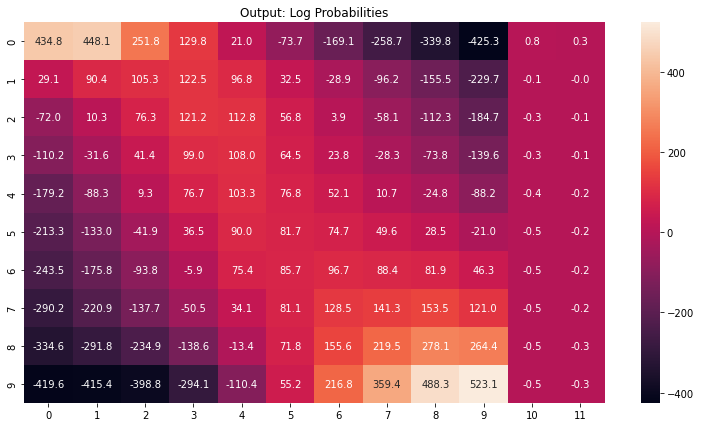

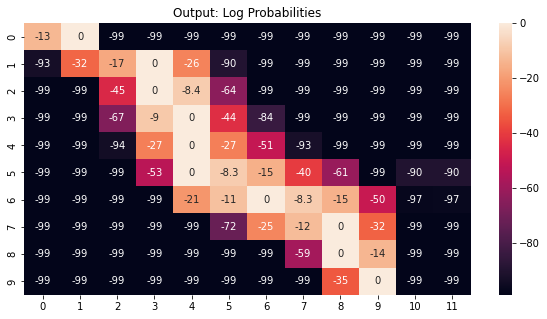

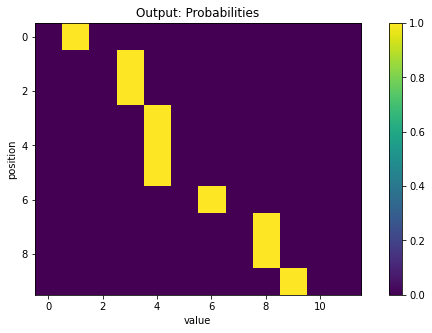

In [557]:
visualize_output_and_attention(cfg, gen_data(1, cfg)[0])

#### Random Permutation

unsorted_sequence tensor([ 0,  0,  0,  0,  8,  8,  8,  8,  8, 11])
sorted_sequence tensor([0, 0, 0, 0, 8, 8, 8, 8, 8])
Actual output: [0, 0, 0, 0, 0, 8, 8, 8, 8, 8]


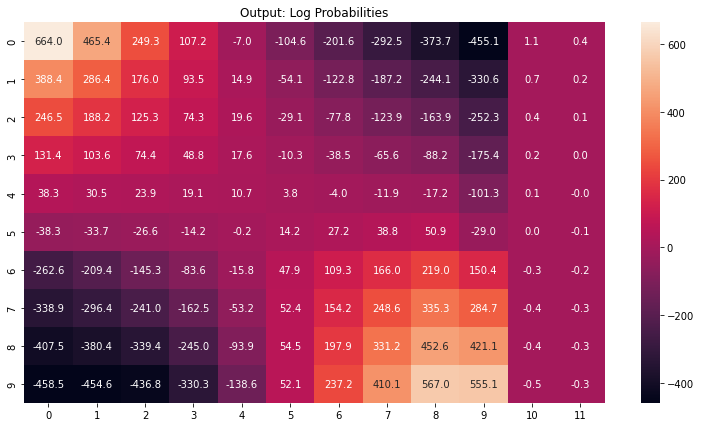

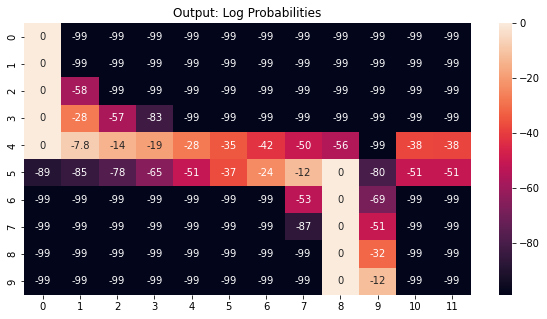

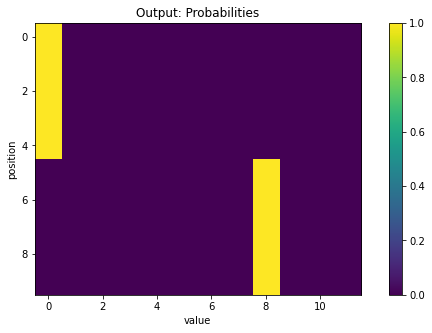

In [558]:
# import random

inp = [0]*5+[8]*5
# random.shuffle(inp)
example = gen_example_from(cfg, inp)

visualize_output_and_attention(cfg, example)

### Adversarial

unsorted_sequence tensor([ 0,  9,  9,  9,  9,  9,  9,  9,  9, 11])
sorted_sequence tensor([0, 9, 9, 9, 9, 9, 9, 9, 9])
Actual output: [0, 0, 9, 9, 9, 9, 9, 9, 9, 9]


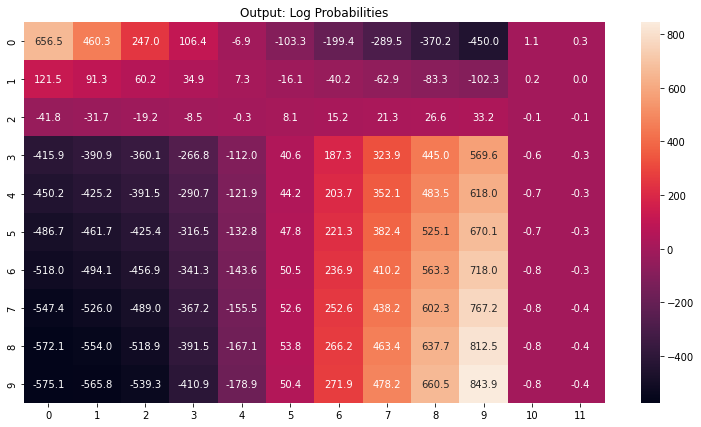

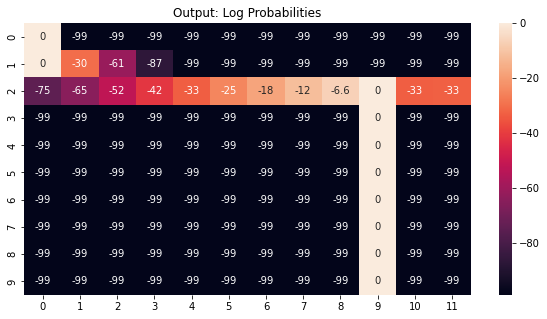

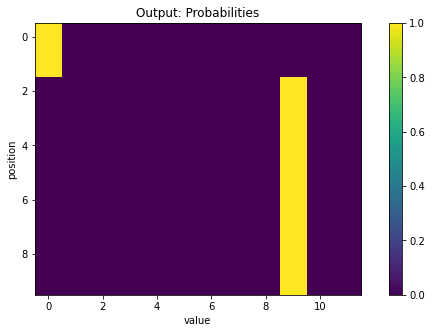

In [559]:
# visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*5 + [1]*5), 15)
# visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*5 + [1]*5), 16)
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5 + [1]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5 + [3] + [7]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]*6 + [7]*4))
visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*2 + [9]*8))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]*5 + [7]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,8,8,8,8,8,8,8,8,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,0,0,0,0,0,0,0,8,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [5,5,5,5,5,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1,1,1,1,1,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1,1,1,1,5,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*9+[1]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[1]*1+[0]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [8]*5+[9]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5+[9]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*6+[0]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5+[1]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[1]*6))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*1+[1]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [2]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [4]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[5]+[6]+[9]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [5]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [8,9,9]+[0]*7))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*9+[0]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [4]*5+[5]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*8+[9]*2))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*10))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]+[8]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]+[9]*9))

## Logit Attributions

torch.Size([2, 1000, 21, 400])
torch.Size([2, 21, 12])
torch.Size([2, 21, 12])


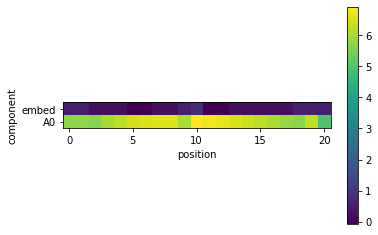

In [560]:
def visualize_logit_attributions_many(cfg: Config, sample_data):
    with torch.inference_mode():
        out, cache = model.run_with_cache(sample_data)
        resid_components = [cache["embed"], cache["attn_out", 0]]

        labels = ["embed", "A0"]
        resid_stack = torch.stack(resid_components, 0)
        resid_stack = resid_stack - resid_stack.mean(-1, keepdim=True)
        print(resid_stack.shape)

        batch_index = 0
        logit_components = resid_stack[:, batch_index] @ model.W_U
        print(logit_components.shape)

        logit_components = logit_components - logit_components.mean(-1, keepdim=True)
        print(logit_components.shape)

        plt.imshow(torch.log(torch.linalg.norm(logit_components, dim=-1).cpu()))
        
        plt.yticks(range(len(labels)), labels)
        plt.ylabel("component")
        plt.xlabel("position")
        plt.colorbar()
        # line(logit_components[:, torch.arange(1, model.cfg.n_ctx).cuda(), tokens[:-1]].T, line_labels=labels)
        # print(cache)
        # print(cache["embed"].shape)
        # print(cache["attn_out", 0].shape)
        # print(cache["mlp_out", 0].shape)

        # print((cache["embed"][0,0] + cache["attn_out", 0][0,0] + cache["mlp_out", 0][0,0]) @ model.W_U)
        # print(out[0, 0])

        # print(model.W_U.shape)
        # model.W_U @ 
        # print(out.shape, out[0])
        # resid_components = [cache["embed"], cache["attn_out", 0], cache["mlp_out", 0], cache["attn_out", 1], cache["mlp_out", 1]]
        # attention_pattern = torch.mean(cache["pattern", 0, "attn"],dim=0)
        # html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data[0]], attention=attention_pattern)
        # return html
    
visualize_logit_attributions_many(cfg, gen_data(1000, cfg))

In [561]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

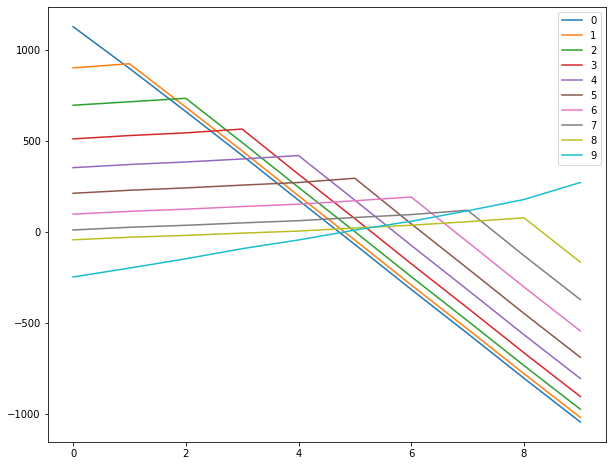

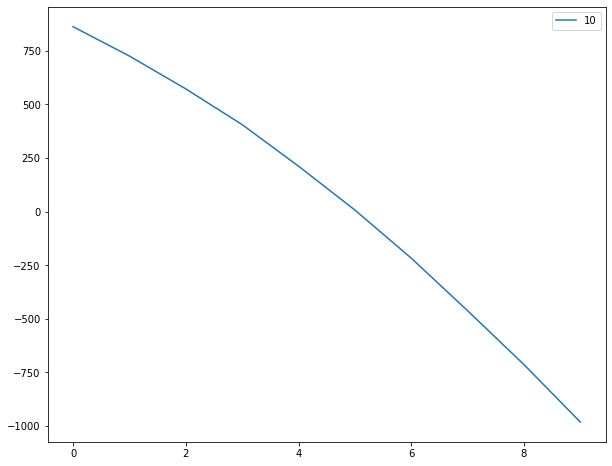

NameError: name 'sns' is not defined

<Figure size 720x576 with 0 Axes>

In [18]:
with torch.inference_mode():
    es=[]
    for tt in range(12):
        emb=model.W_E[tt]
        if tt<10:
            emb=emb+model.W_pos[1]
        elif tt==10:
            emb=emb+model.W_pos[0]
        elif tt==11:
            emb=emb+model.W_pos[11]
        s=emb@model.W_V+model.b_V
        s=s@model.W_O+model.b_O
        s=s.squeeze()
        s=s@model.W_U+model.b_U
        es.append(s.tolist())
    plt.figure(figsize=(10,8))
    for t in range(10):
        plt.plot(es[t][:10],label=str(t))
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,8))
    for t in range(10,11):
        plt.plot(es[t][:10],label=str(t))
    plt.legend()
    plt.show()
    es=torch.tensor(es)
    plt.figure(figsize=(10,8))
    sns.heatmap(es, cmap="YlGnBu", annot=True, fmt=".1f")
    plt.show()
    es=torch.softmax(es, dim=-1)
    sns.heatmap(es, cmap="YlGnBu")

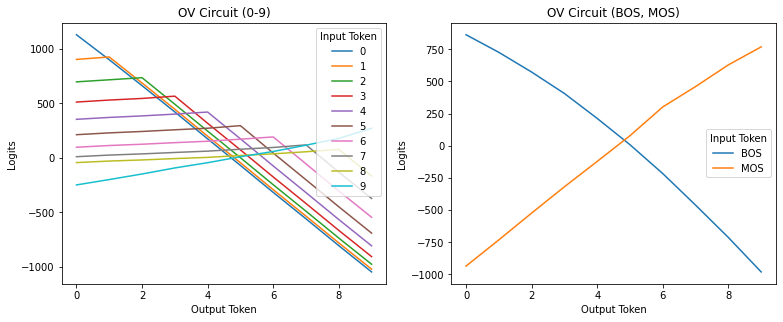

In [27]:
with torch.inference_mode():
    es=[]
    for tt in range(12):
        emb=model.W_E[tt]
        if tt<10:
            emb=emb+model.W_pos[1]
        elif tt==10: # BOS
            emb=emb+model.W_pos[0]
        elif tt==11:
            emb=emb+model.W_pos[11]
        s=emb@model.W_V+model.b_V
        s=s@model.W_O+model.b_O
        s=s.squeeze()
        s=s@model.W_U+model.b_U
        es.append(s.tolist())

    fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
    for label in range(2):
        inputs = "0-9"
        if label == 1:
            inputs = "BOS, MOS"
        ax[label].set_title(f"OV Circuit ({inputs})")
        ax[label].set_xlabel("Output Token")
        ax[label].set_ylabel("Logits")
        if label == 0:
            for tt in range(10):
                ax[label].plot(es[tt][:10],label=str(tt))
        else:
            for tt in range(10,12):
                ax[label].plot(es[tt][:10],label=("BOS" if tt==10 else "MOS"))
        ax[label].legend(title="Input Token")
    plt.show()

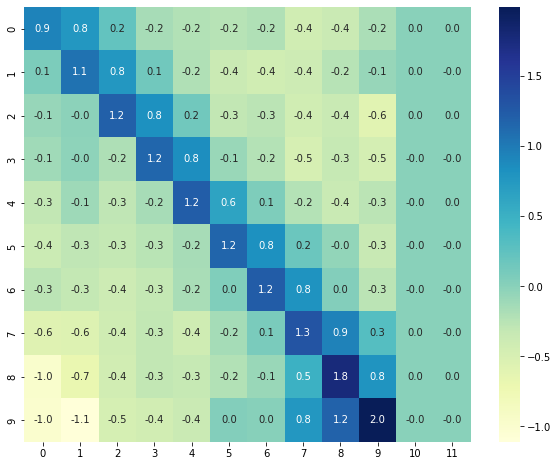

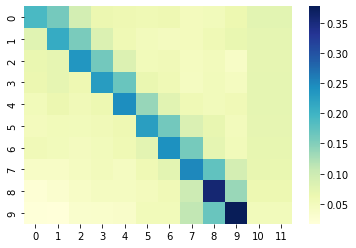

In [504]:
with torch.inference_mode():
    es=[]
    for tt in range(0,10):
        s=model.W_E[tt]
        s=s@model.W_U+model.b_U
        es.append(s.tolist())
    es=torch.tensor(es)
    plt.figure(figsize=(10,8))
    sns.heatmap(es, cmap="YlGnBu", annot=True, fmt=".1f")
    plt.show()
    es=torch.softmax(es, dim=-1)
    sns.heatmap(es, cmap="YlGnBu")

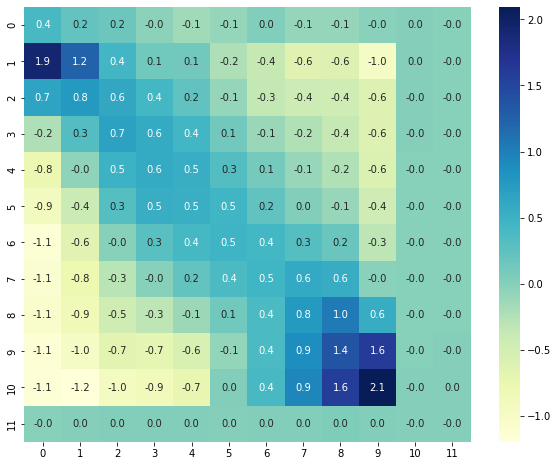

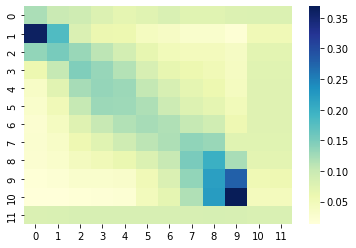

In [505]:
with torch.inference_mode():
    es=[]
    for tt in range(10,22):
        s=model.W_pos[tt]
        s=s@model.W_U+model.b_U
        es.append(s.tolist())
    es=torch.tensor(es)
    plt.figure(figsize=(10,8))
    sns.heatmap(es, cmap="YlGnBu", annot=True, fmt=".1f")
    plt.show()
    es=torch.softmax(es, dim=-1)
    sns.heatmap(es, cmap="YlGnBu")

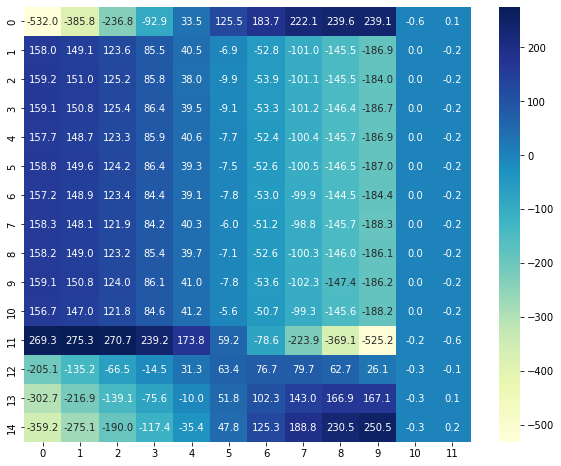

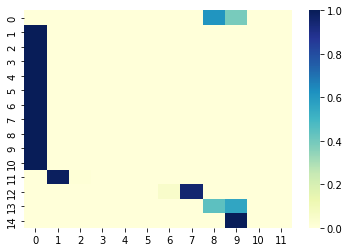

In [506]:
with torch.inference_mode():
    es=[]
    for tt in range(15):
        emb=model.W_pos[tt]
        s=emb@model.W_V+model.b_V
        s=s@model.W_O+model.b_O
        s=s.squeeze()
        s=s@model.W_U+model.b_U
        es.append(s.tolist())
    es=torch.tensor(es)
    plt.figure(figsize=(10,8))
    sns.heatmap(es, cmap="YlGnBu", annot=True, fmt=".1f")
    plt.show()
    es=torch.softmax(es, dim=-1)
    sns.heatmap(es, cmap="YlGnBu")

### Attn 0

#### QK (Position)

As expected, for a fixed query position, it pays approximately equal attention to the keys correpsonding to positions 1 through 10.

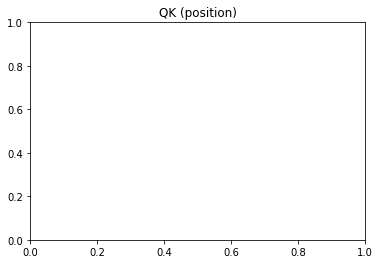

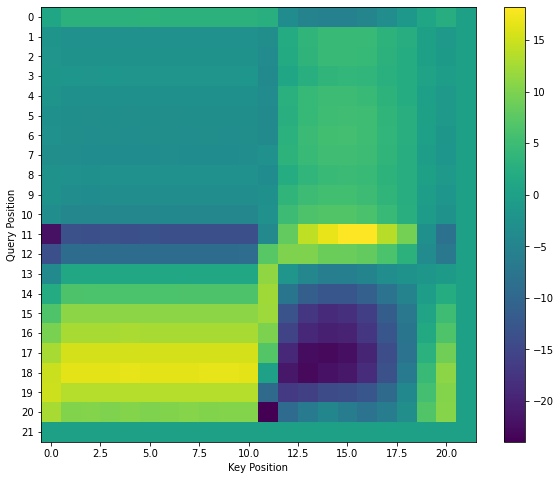

In [507]:
with torch.inference_mode():
    QK = model.W_pos @ model.W_Q[0, 0] @ model.W_K[0, 0].T @ model.W_pos.T
    plt.title("QK (position)")
    plt.figure(figsize=(10,8))
    plt.imshow(QK.cpu())
    plt.colorbar()
    plt.ylabel("Query Position")
    plt.xlabel("Key Position")
    plt.yticks(range(QK.shape[0]))

In [508]:
def plot_qk_for_out(pos: Optional[int] = None):
    """Pos: position you are trying to predict"""
    print("pos =", pos)
    with torch.inference_mode():
        embeds = model.W_E.clone()
        if pos is not None:
            embeds += model.W_pos[11 + pos] # 11 is MOS
        fig, ax = plt.subplots(1,2,figsize=(12.8, 4.8))
        for head in range(1):
            QK = (embeds @ model.W_Q[0, head] + model.b_Q[0, head]) @ (model.W_E @ model.W_K[0, head] + model.b_K[0, head]).T
            QK = QK/np.sqrt(cfg.d_model)
            ax[0].set_title(f"QK For Position {pos} Head {head}")
            QK = QK[:12, :12]
            heatmap0(QK.cpu(), ax=ax[0])
            ax[0].set_ylabel("Query Value")
            ax[0].set_xlabel("Key Value")
            ax[1].set_title(f"EXP-QK For Position {pos} Head {head}")
            QK = torch.exp(QK)
            heatmap0(QK.cpu(), ax=ax[1])
            ax[1].set_ylabel("Query Value")
            ax[1].set_xlabel("Key Value")
        plt.tight_layout()

# def compute_logits(example, pos_at):
#     with torch.inference_mode():
#         out, cache = model.run_with_cache(example)
#         embeds = model.W_E[example].squeeze()
#         max_dif(embeds, cache['embed'].squeeze())
#         pos_embeds = model.W_pos[torch.arange(example.shape[0])].squeeze()
#         max_dif(pos_embeds, cache['pos_embed'].squeeze())
#         resids = embeds + pos_embeds
#         Q = resids @ model.W_Q[0, 0] + model.b_Q[0, 0]
#         K = resids @ model.W_K[0, 0] + model.b_K[0, 0]
#         print(Q[0])
#         print(cache['q', 0, 0].squeeze()[0])
#         assert False
#         row = (Q @ K.T)[pos_at]
#         row[pos_at:] = -10000
#         row -= row.max()
#         print(torch.exp(row))
#         # print(Q.shape, K.shape)

# compute_logits(gen_example_from(cfg, [0]+[2]+[7]*8), 12)

In [509]:
def plot_pqk_for_out():
    with torch.inference_mode():
        embeds = model.W_pos[12:]
        print(model.cfg.n_ctx)
        fig, ax = plt.subplots(1,2,figsize=(12.8, 4.8))
        for head in range(1):
            QK = (embeds @ model.W_Q[0, head] + model.b_Q[0, head]) @ (model.W_E @ model.W_K[0, head] + model.b_K[0, head]).T
            QK = QK/np.sqrt(cfg.d_model)
            ax[0].set_title(f"PQK Head {head}")
            QK = QK[:12, :12]
            heatmap0(QK.cpu(), ax=ax[0])
            ax[0].set_ylabel("Query Value")
            ax[0].set_xlabel("Key Value")
            ax[1].set_title(f"EXP-PQK Head {head}")
            QK = torch.exp(QK)
            heatmap0(QK.cpu(), ax=ax[1])
            ax[1].set_ylabel("Query Value")
            ax[1].set_xlabel("Key Value")
        plt.tight_layout()

# def compute_logits(example, pos_at):
#     with torch.inference_mode():
#         out, cache = model.run_with_cache(example)
#         embeds = model.W_E[example].squeeze()
#         max_dif(embeds, cache['embed'].squeeze())
#         pos_embeds = model.W_pos[torch.arange(example.shape[0])].squeeze()
#         max_dif(pos_embeds, cache['pos_embed'].squeeze())
#         resids = embeds + pos_embeds
#         Q = resids @ model.W_Q[0, 0] + model.b_Q[0, 0]
#         K = resids @ model.W_K[0, 0] + model.b_K[0, 0]
#         print(Q[0])
#         print(cache['q', 0, 0].squeeze()[0])
#         assert False
#         row = (Q @ K.T)[pos_at]
#         row[pos_at:] = -10000
#         row -= row.max()
#         print(torch.exp(row))
#         # print(Q.shape, K.shape)

# compute_logits(gen_example_from(cfg, [0]+[2]+[7]*8), 12)

pos = None


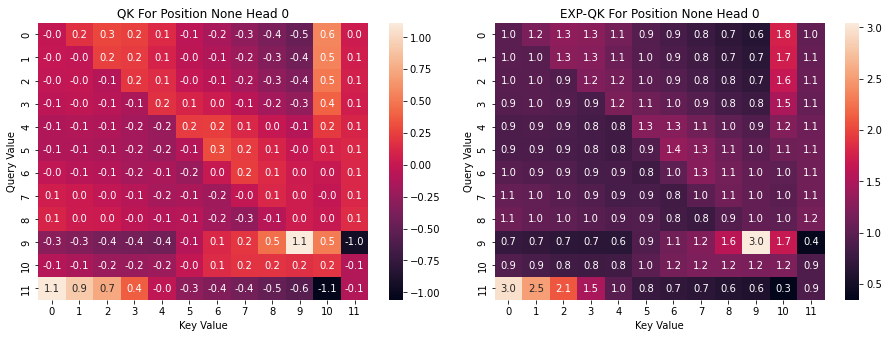

In [510]:
plot_qk_for_out()

22


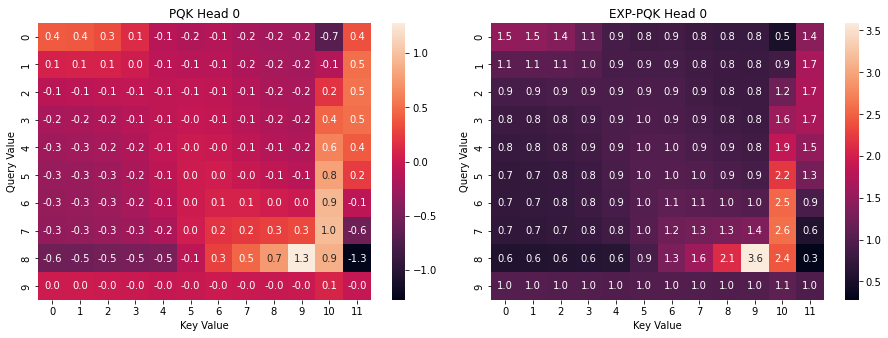

In [511]:
plot_pqk_for_out()

position 8
tensor([0.7086, 0.7183, 0.7380, 0.7610, 0.8365, 1.0234, 1.2016, 1.2545, 1.3004,
        1.3533, 2.5910, 0.5731], device='cuda:0')


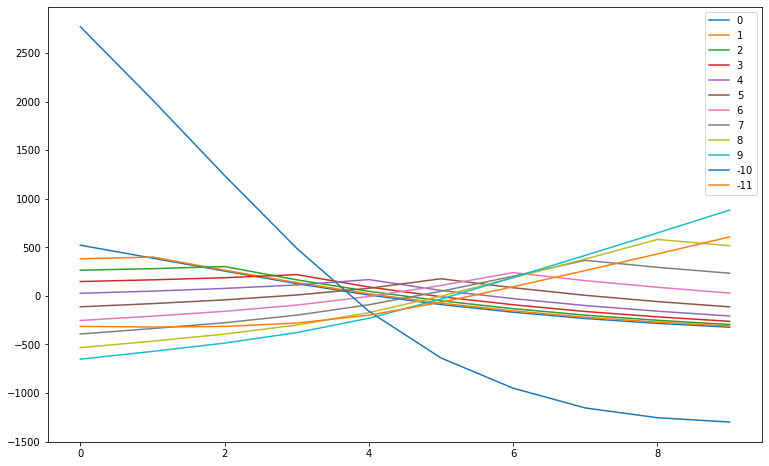

In [512]:
with torch.inference_mode():
    embeds = model.W_pos[11:]
#    fig, ax = plt.subplots(1,2,figsize=(12.8, 4.8))
    for head in range(1):
        QK = (embeds @ model.W_Q[0, head] + model.b_Q[0, head]) @ (model.W_E @ model.W_K[0, head] + model.b_K[0, head]).T
        QK = QK/np.sqrt(cfg.d_model)
    pos=8
    print('position',pos)
    QK = torch.exp(QK[pos])
    print(QK)
    es=[]
    for tt in range(12):
        emb=model.W_E[tt]
        if tt<10:
            emb=emb+model.W_pos[1]
        elif tt==10:
            emb=emb+model.W_pos[0]
        elif tt==11:
            emb=emb+model.W_pos[11]
        s=emb@model.W_V+model.b_V
        s=s@model.W_O+model.b_O
        s=s.squeeze()
        s=s@model.W_U+model.b_U
        if tt>=10:
            s=-s
        s=s*QK[tt]
        es.append(s[:10])
    plt.figure(figsize=(12.8, 8))
    for a in range(len(es)):
        plt.plot(es[a].cpu(),label=("-" if a>=10 else "")+str(a))
    plt.legend()
    plt.show()

pos = 0
pos = 1
pos = 4
pos = 7


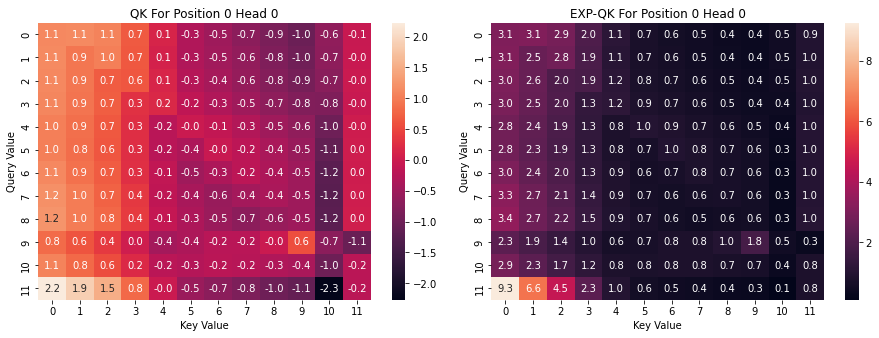

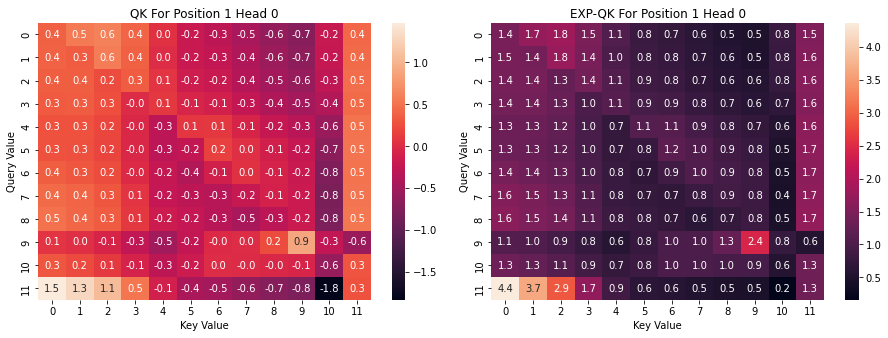

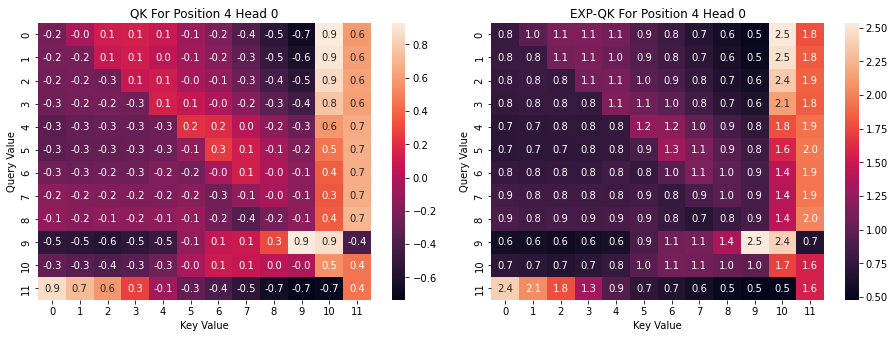

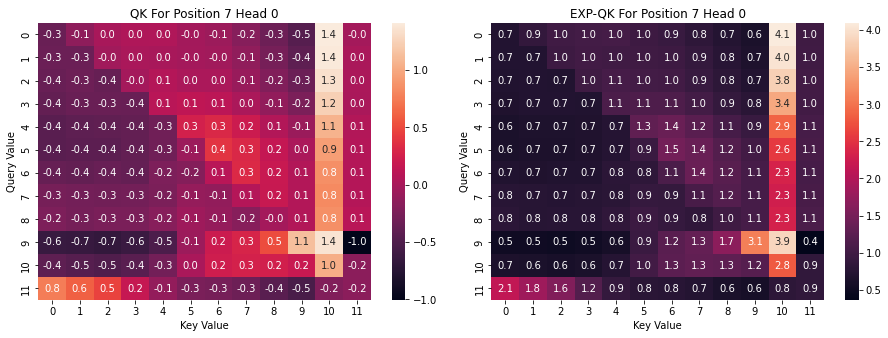

In [513]:
for pos in [0,1,4,7]:
    plot_qk_for_out(pos)

In [515]:
model.W_Q[0][0]

tensor([[-0.0195,  0.0904,  0.0601,  ...,  0.0226, -0.0005, -0.0402],
        [-0.0491,  0.0284, -0.0464,  ...,  0.0315, -0.0283,  0.0193],
        [ 0.0224,  0.0397,  0.0572,  ...,  0.0260, -0.0233, -0.0560],
        ...,
        [-0.0155, -0.0200,  0.0069,  ..., -0.0078,  0.0689,  0.1197],
        [-0.0496, -0.0050, -0.0034,  ...,  0.0121, -0.0422, -0.0281],
        [ 0.0506,  0.0251, -0.0230,  ..., -0.0582, -0.0871,  0.0122]],
       device='cuda:0')

unsorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Actual output: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


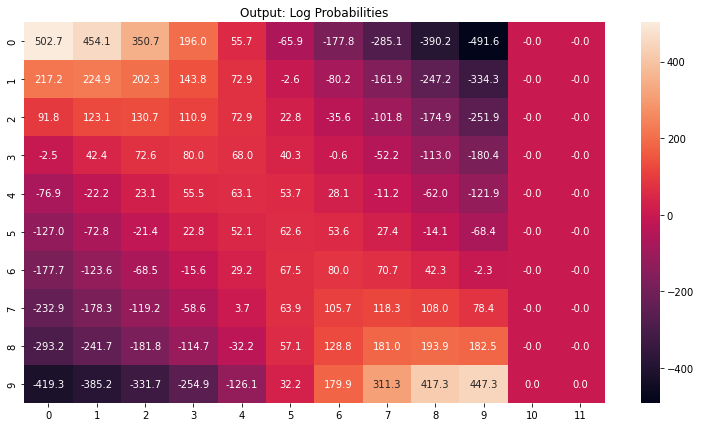

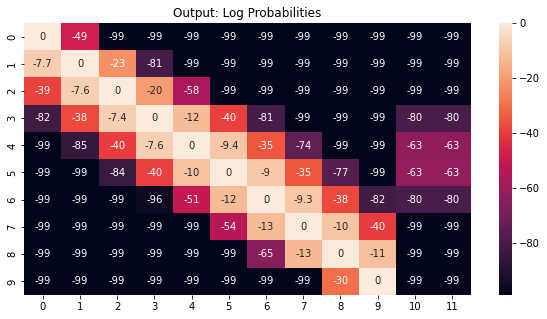

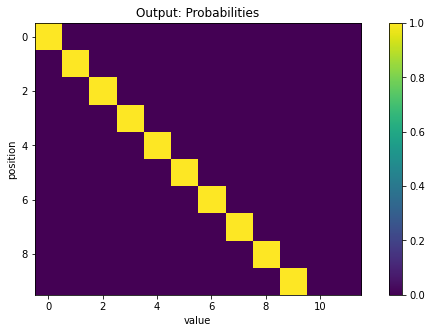

In [403]:
visualize_output_and_attention(cfg, gen_example_from(cfg, list(range(10))))

unsorted_sequence tensor([5, 5, 5, 8, 9, 9, 9, 9, 9, 9])
sorted_sequence tensor([5, 5, 5, 8, 9, 9, 9, 9, 9, 9])
Actual output: [5, 5, 5, 8, 9, 9, 9, 9, 9, 9]


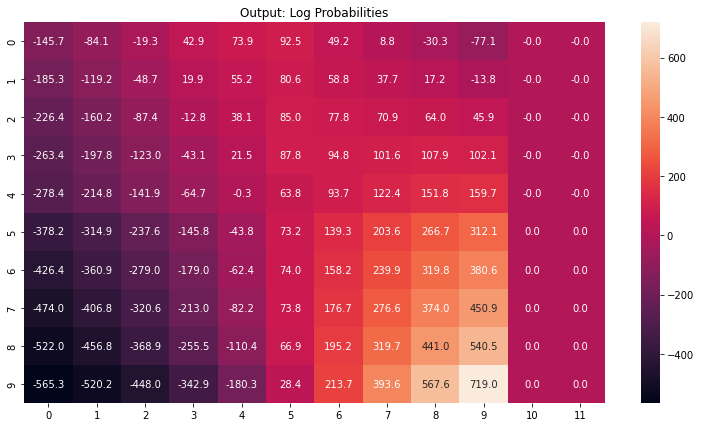

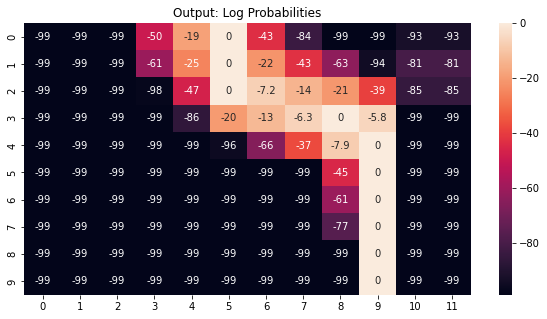

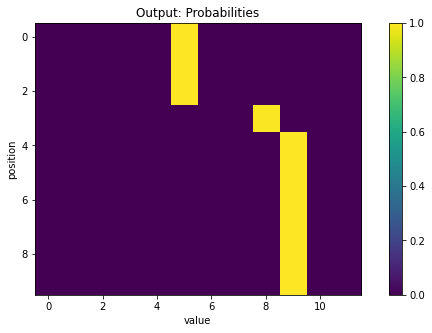

In [404]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [5,5,5,8]+[9]*6))


unsorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Actual output: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


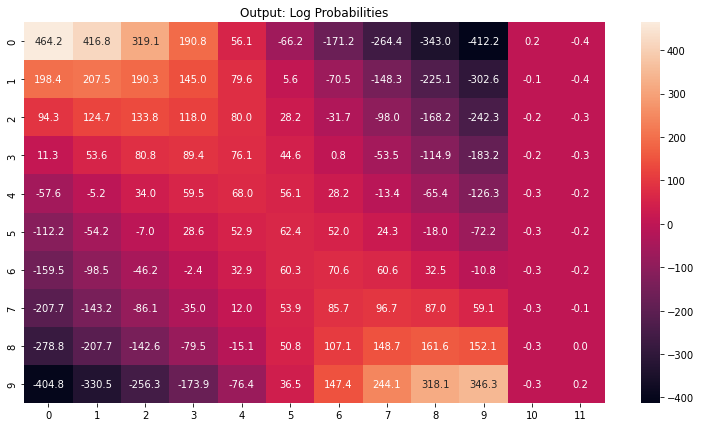

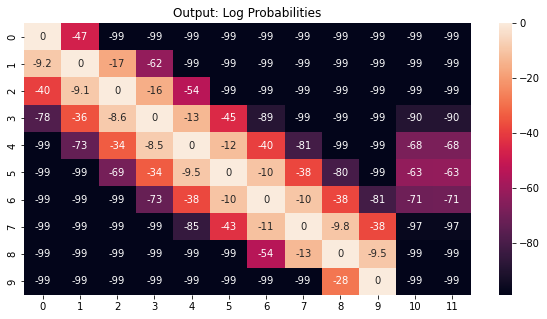

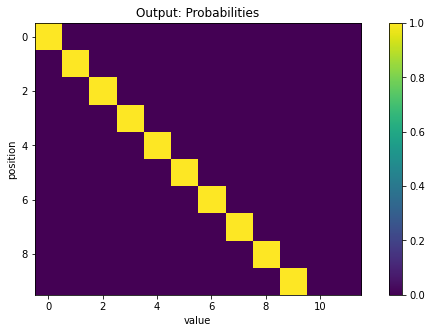

In [516]:
visualize_output_and_attention(cfg, gen_example_from(cfg,list(range(10))))

unsorted_sequence tensor([0, 0, 0, 5, 7, 7, 7, 7, 7, 7])
sorted_sequence tensor([0, 0, 0, 5, 7, 7, 7, 7, 7, 7])
Actual output: [0, 0, 0, 5, 7, 7, 7, 7, 7, 7]


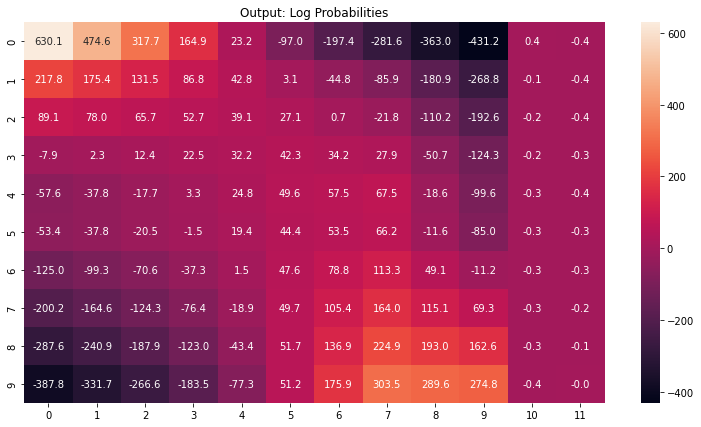

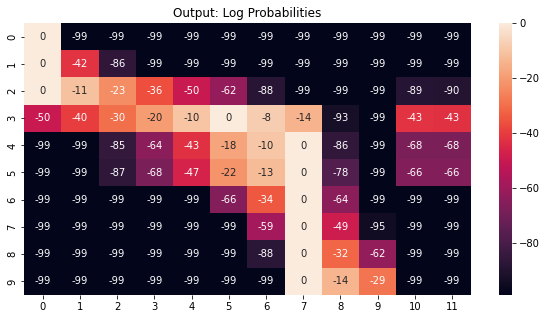

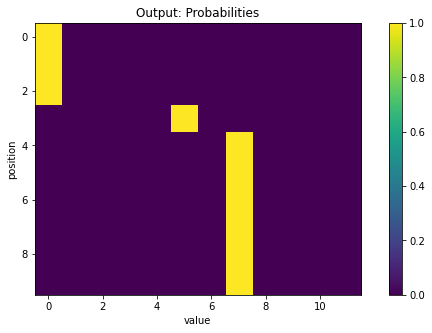

In [517]:
# QK for position 14
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 0, 0, 5] + [7]*6))

pos = 2


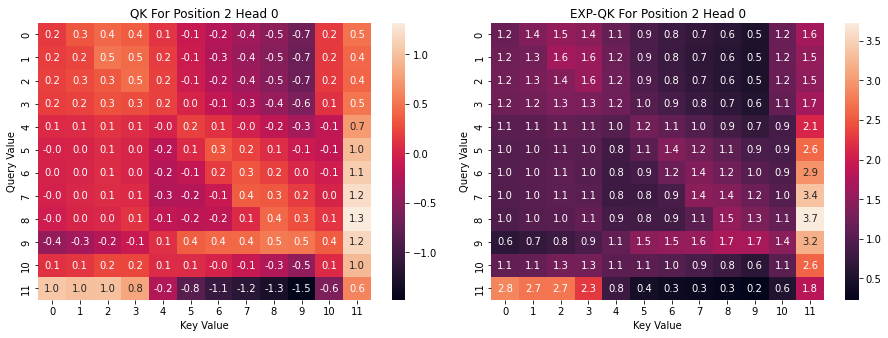

In [407]:
plot_qk_for_out(2)

pos = 1


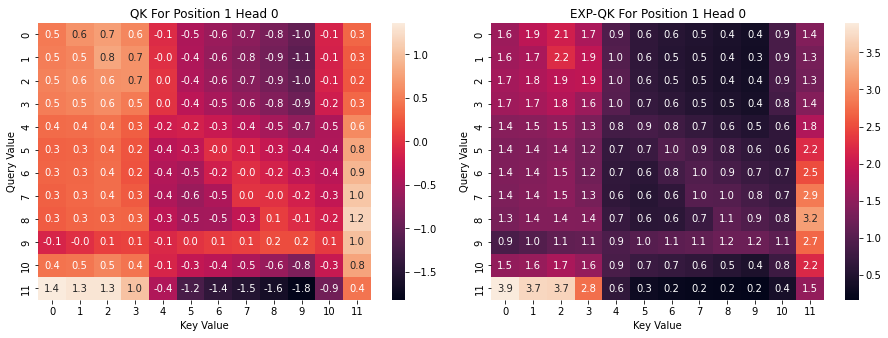

In [408]:
plot_qk_for_out(1)

unsorted_sequence tensor([0, 0, 6, 7, 7, 7, 7, 7, 7, 7])
sorted_sequence tensor([0, 0, 6, 7, 7, 7, 7, 7, 7, 7])
Actual output: [0, 0, 6, 7, 7, 7, 7, 7, 7, 7]


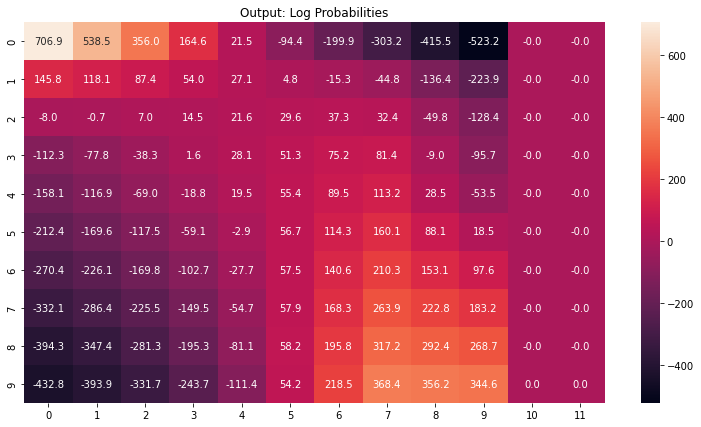

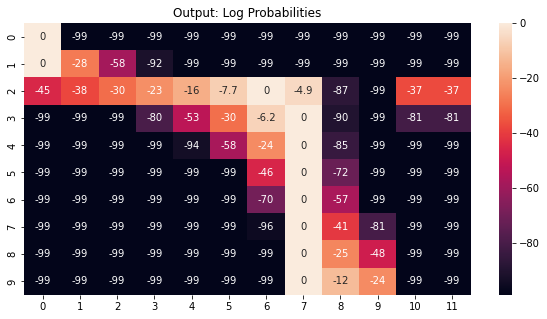

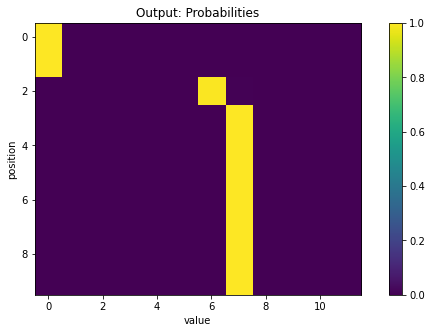

In [409]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 0, 6] + [7]*7))

In [410]:
def max_dif(a: torch.Tensor, b: torch.Tensor):
    assert a.shape == b.shape, f"found different shapes {a.shape} {b.shape}"
    print("max_dif =", torch.max(torch.abs(a-b)))

unsorted_sequence tensor([0, 6, 7, 7, 7, 7, 7, 7, 7, 7])
sorted_sequence tensor([0, 6, 7, 7, 7, 7, 7, 7, 7, 7])
Actual output: [0, 6, 7, 7, 7, 7, 7, 7, 7, 7]


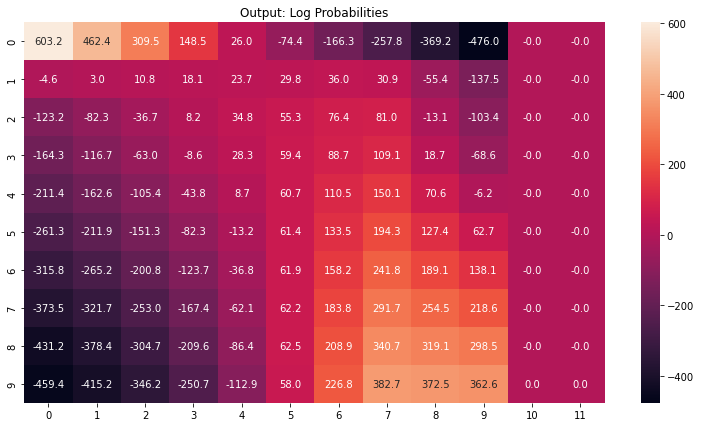

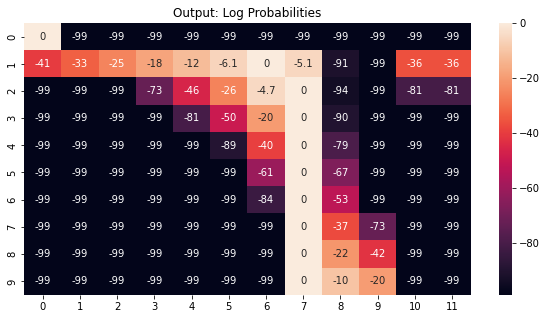

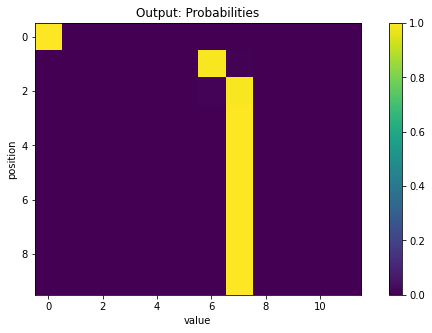

In [411]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 6] + [7]*8))

unsorted_sequence tensor([0, 5, 9, 9, 9, 9, 9, 9, 9, 9])
sorted_sequence tensor([0, 5, 9, 9, 9, 9, 9, 9, 9, 9])
Actual output: [0, 5, 9, 9, 9, 9, 9, 9, 9, 9]


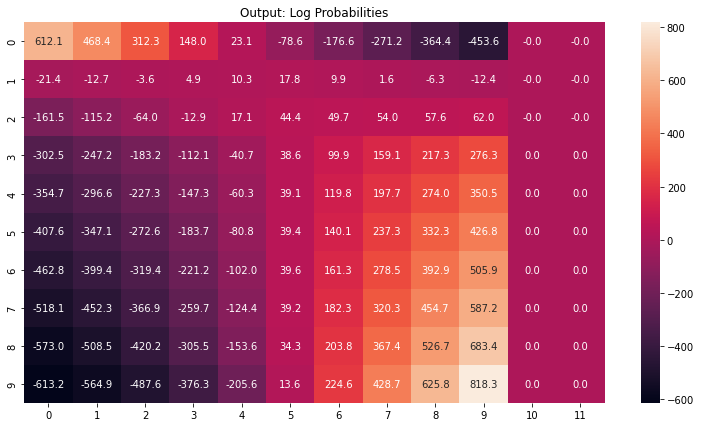

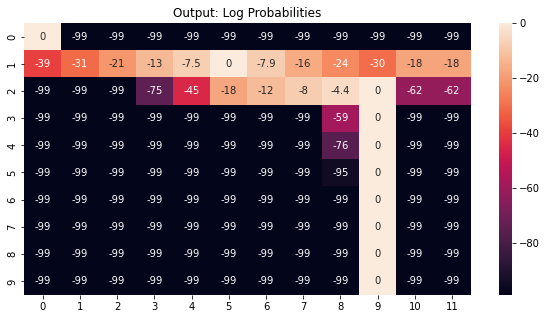

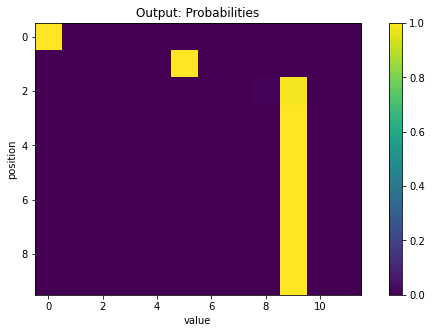

In [412]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 5] + [9]*8))

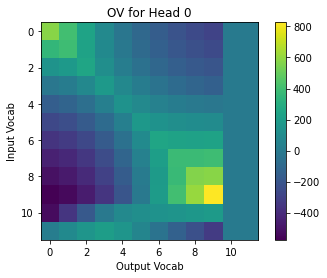

In [413]:
with torch.inference_mode():
    for head in range(1):
        OV = model.W_E @ model.W_V[0, head] @ model.W_O[0, head] @ model.W_U

        plt.figure()
        plt.title(f"OV for Head {head}")
        plt.imshow(OV.cpu())
        plt.colorbar()
        plt.ylabel("Input Vocab")
        plt.xlabel("Output Vocab")

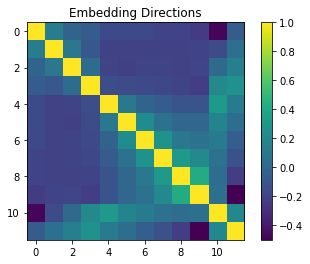

In [414]:
with torch.inference_mode():
    plt.title("Embedding Directions")
    embedding_vectors = model.W_E.clone()
    embedding_vectors /= torch.linalg.norm(embedding_vectors, dim=-1, keepdim=True)
    plt.imshow((embedding_vectors @ embedding_vectors.T).cpu())
    plt.colorbar()

## Hypothesis

1-head: The model is implementing something like the following function:

```py
def element_at_pos(s: set, prev_val: int, pos: int):
    if s.count_greater_than(prev_val) >= len(s) - pos: 
        # ^ note: the above inequality cannot be strict
        return s.get_min_greater_than(prev_val)
        # ^ this can easily be obtained assuming transformer only pays attention to tokens with value > prev_val
        # a token increases the logit corresponding to its value. tokens with lower values result in higher increases
    else:
        return prev_val
```

Equivalently:

```
out_val =
BIG * (# >= val) + val if val > prev_val
BIG * (len(s) - pos) + val if val <= prev_val
```

but the transformer looks like:

```
BIG * f(# >= val / (# >= prev_val + smth depending on pos and prev_val)) + val if val >= prev_val
+ BIG * f((smth depending on pos and prev_val) / (# >= prev_val + smth depending on pos and prev_val)) + val for val = prev_val
```

What we know:
 - Transformer filters out everything `< prev_val`.
 - Transformer does pay attention to things with value equal to `prev_val` (why?).

WRONG:

Actually, to predict the next token in the output sequence, we only need a linear layer taking as input:
 - sum of the embeddings for each value in the input sequence
 - embedding of the previous value in the output sequence
 - embedding of the current position

In [415]:
# from sklearn.decomposition import PCA
# pcaer = PCA(n_components=10)
# pcas=pcaer.fit_transform(model.W_E.T.detach().cpu().numpy())


# fig, ax = plt.subplots()
# z=pcas[:10,2]
# y=pcas[:10,1]
# ax.scatter(z, y)

# for i in range(len(z)):
#     ax.annotate(str(i), (z[i], y[i]))